In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import polars as pl
from polars import col
import plotly.express as px

from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX

# EDA

In [17]:
data = pd.read_csv("data/PA6_cleaned_dataset.csv", index_col='time')
data = data.drop(data.columns[0], axis = 1)
data.index = pd.to_datetime(data.index, format='%m/%d/%Y')

**The only null values we have are in the target variable "best price compound" and stretch over an 18 month period from "1/1/2015" to "6/1/2016"**

In [18]:
pl.from_pandas(data, include_index=True).null_count()

time,PA6 GLOBAL_ EMEAS _ EUR per TON,CRUDE_PETRO,CRUDE_BRENT,CRUDE_DUBAI,CRUDE_WTI,NGAS_US,NGAS_EUR,NGAS_JP,iNATGAS,best_price_compound,Benzene_price,Caprolactam_price,Cyclohexane_price,Electricty_Price_France,Electricty_Price_Italy,Electricty_Price_Poland,Electricty_Price_Netherlands,Electricty_Price_Germany,Inflation_rate_france,Automotive Value
u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32
0,0,0,0,0,0,0,0,0,0,18,0,0,0,0,0,0,0,0,0,0


## Seasonal Decomposition

**The best buy price initially varies on a monthly basis and then starting 7/1 2019 it varies either every 3 or every 6 months.**
The trend component seems to follow a very large cycle, and is probably due to macro-economic factors. The scale of the seasonal component is very small compared to the trend. 

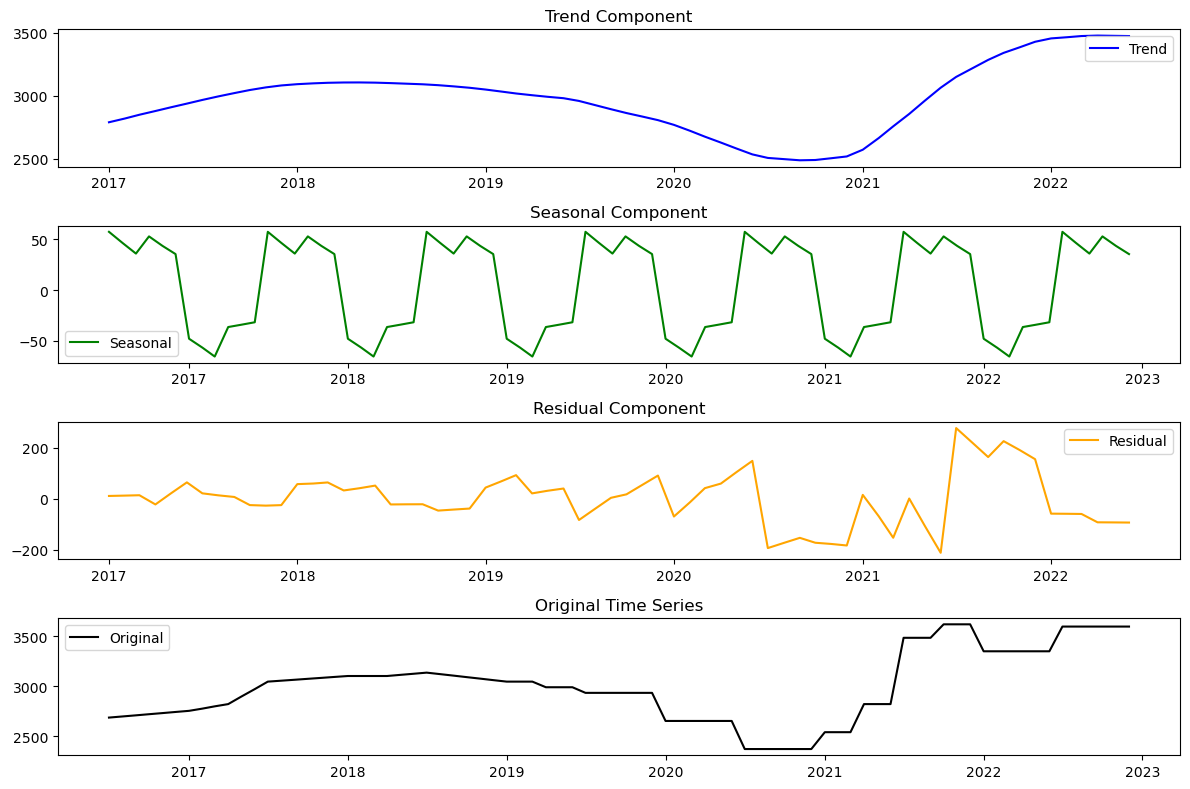

In [20]:
# Seasonal Decomposition
decomposition = seasonal_decompose(data.dropna()['best_price_compound'], model='additive', period=12) 
plt.figure(figsize=(12, 8))
# Trend component
plt.subplot(411)
plt.plot(decomposition.trend, label='Trend', color='blue')
plt.legend()
plt.title('Trend Component')
# Seasonal component
plt.subplot(412)
plt.plot(decomposition.seasonal, label='Seasonal', color='green')
plt.legend()
plt.title('Seasonal Component')
# Residual component
plt.subplot(413)
plt.plot(decomposition.resid, label='Residual', color='orange')
plt.legend()
plt.title('Residual Component')
# Original time series
plt.subplot(414)
plt.plot(data['best_price_compound'], label='Original', color='black')
plt.legend()
plt.title('Original Time Series')
plt.tight_layout()
plt.show()

## Correlations

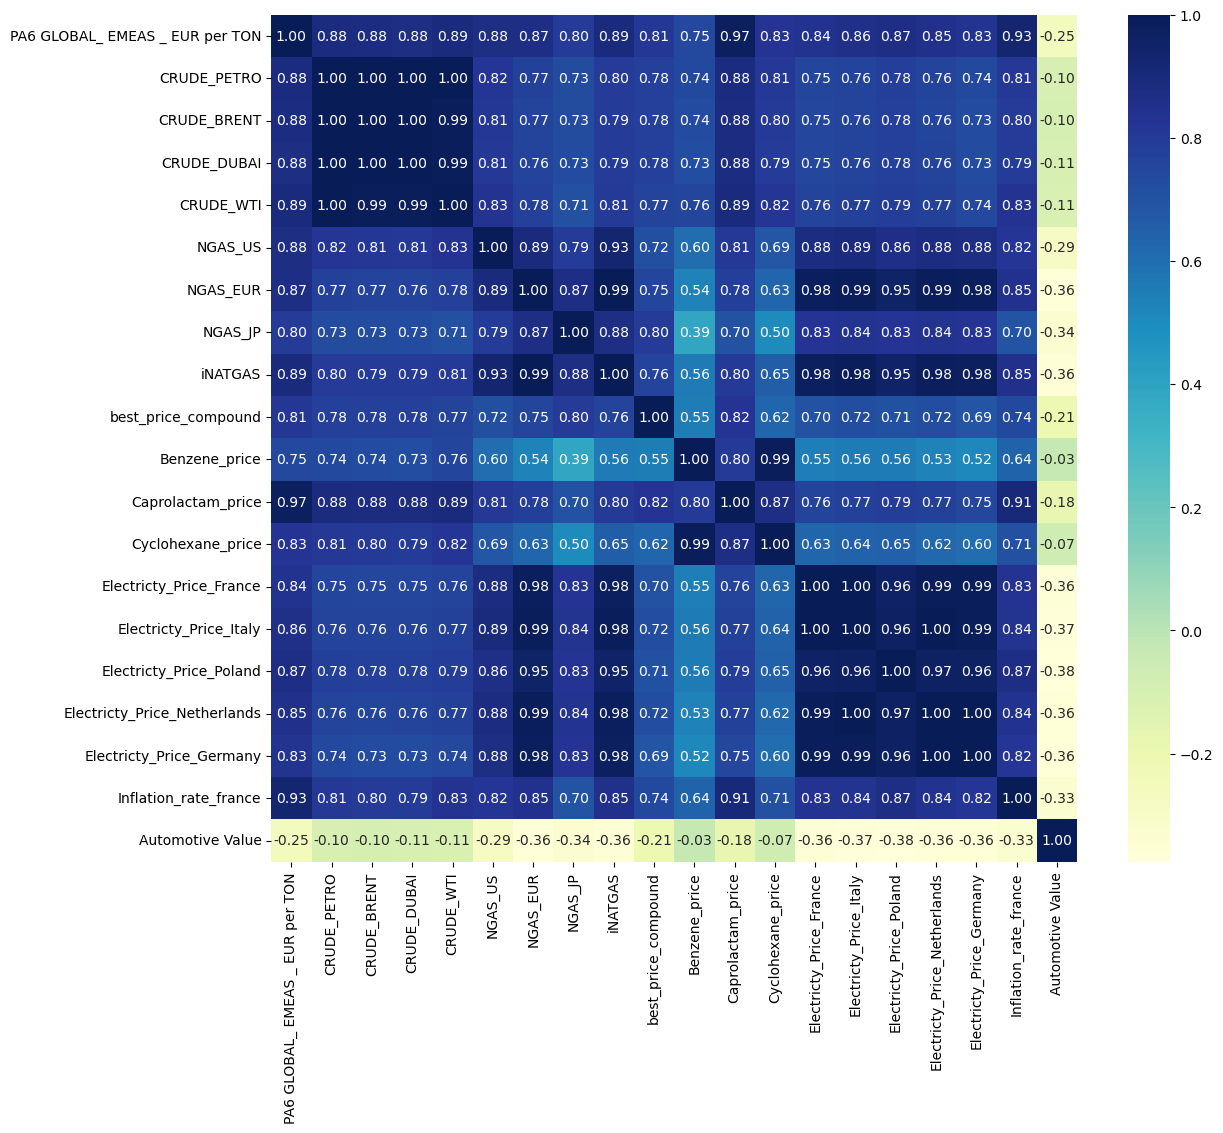

In [4]:
plt.figure(figsize=(13, 11))
sns.heatmap(data.corr(), annot=True, cmap = 'YlGnBu', fmt=".2f") 
plt.show()

## Plots by group

**Let us first look at the evolution of all of our variables. We are interested in observing common trends and correlations, so we will first rescale/normalize our variables so they range from 0 to 1, and then we will inspect them groupwise**

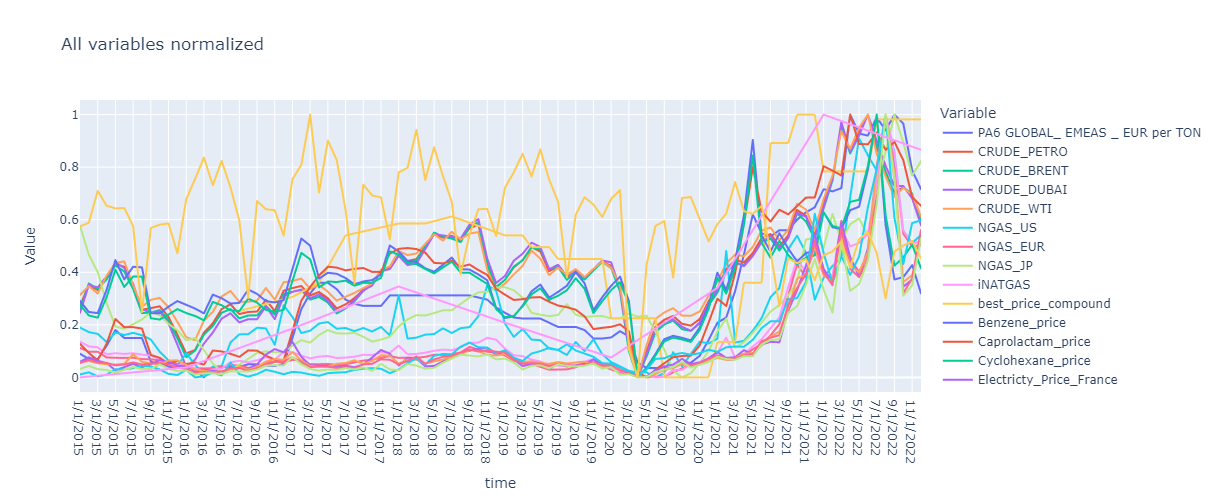

In [74]:
scaler = MinMaxScaler()
df_normalized = pd.DataFrame(scaler.fit_transform(data), index=data.index, columns=data.columns)
df_melted = df_normalized.reset_index().melt(id_vars=df_normalized.index.name, var_name='Variable', value_name='Value')
fig = px.line(df_melted, x=df_normalized.index.name, y='Value', color='Variable', title='All variables normalized')
fig.update_layout(width=1300, height=500)
fig.show()

**There seems to be a general upwards trend towards the end of the period, but this view is too unclear, let us inspect the variables groupwise.**

In [119]:
petro = ['CRUDE_PETRO', 'CRUDE_BRENT', 'CRUDE_DUBAI', 'CRUDE_WTI']
gas = ['NGAS_US', 'NGAS_EUR', 'NGAS_JP', 'iNATGAS']
chemicals = ['Benzene_price', 'Caprolactam_price', 'Cyclohexane_price']
electricity = ['Electricty_Price_France', 'Electricty_Price_Italy', 'Electricty_Price_Poland','Electricty_Price_Netherlands', 'Electricty_Price_Germany']
rest = ['PA6 GLOBAL_ EMEAS _ EUR per TON', 'best_price_compound', 'Inflation_rate_france', 'Automotive Value']

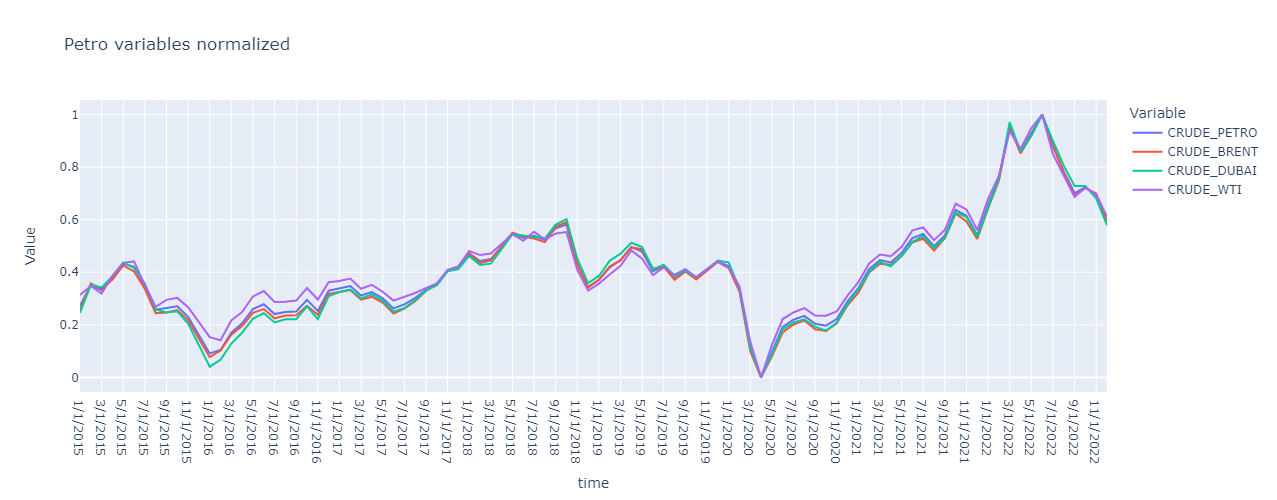

In [117]:
subcols = petro
df_selected = df_normalized.loc[:, subcols]
df_melted = df_selected.reset_index().melt(id_vars=df_selected.index.name, var_name='Variable', value_name='Value')
fig = px.line(df_melted, x=df_selected.index.name, y='Value', color='Variable', title='Petro variables normalized')
fig.update_layout(width=1300, height=500)
fig.show()

**We can definitely regroup all petro columns into one, because they evolve near identically**

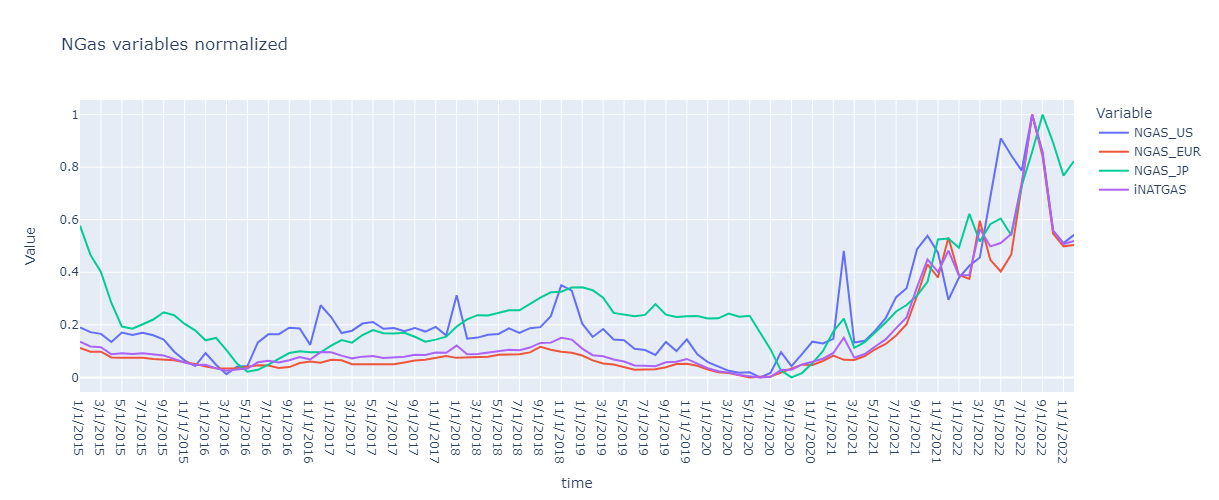

In [118]:
subcols = gas
df_selected = df_normalized.loc[:, subcols]
df_melted = df_selected.reset_index().melt(id_vars=df_selected.index.name, var_name='Variable', value_name='Value')
fig = px.line(df_melted, x=df_selected.index.name, y='Value', color='Variable', title='NGas variables normalized')
fig.update_layout(width=1300, height=500)
fig.show()

**Natural Gas indices are also highly correlated among themselves, however the PA6 Global index is most correlated with iNATGAS, so we will only keep that value**

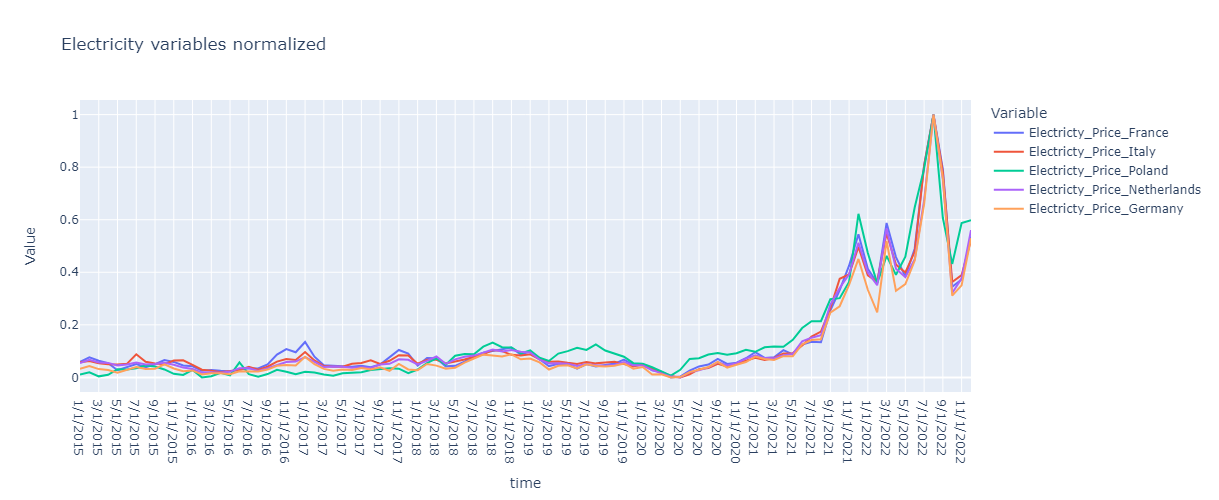

In [78]:
subcols = electricity
df_selected = df_normalized.loc[:, subcols]
df_melted = df_selected.reset_index().melt(id_vars=df_selected.index.name, var_name='Variable', value_name='Value')
fig = px.line(df_melted, x=df_selected.index.name, y='Value', color='Variable', title='Electricity variables normalized')
fig.update_layout(width=1300, height=500)
fig.show()

**Electricity prices as well, we will average them or only consider that of one country, because the trends are the same**

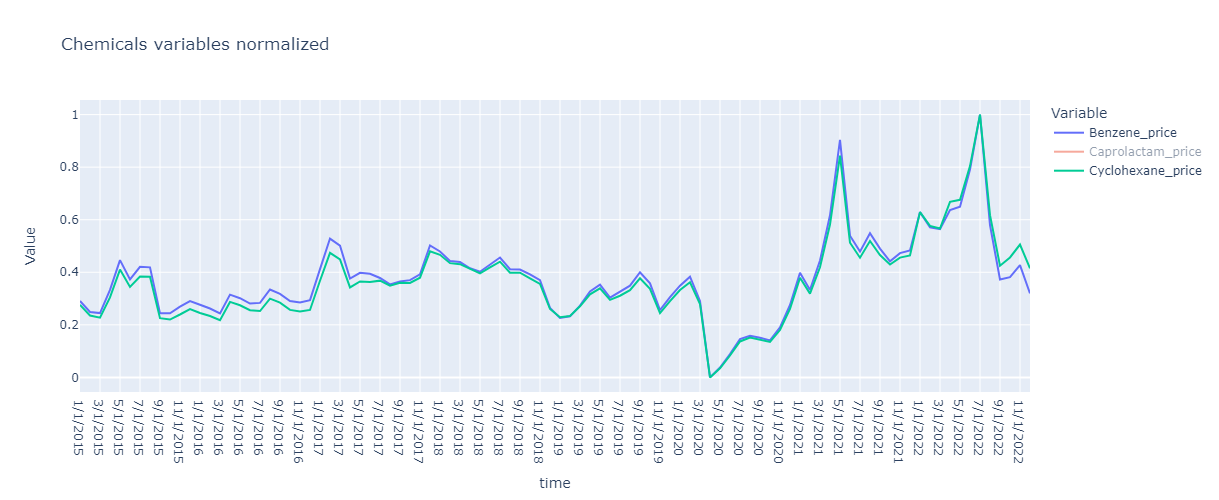

In [79]:
subcols = chemicals
df_selected = df_normalized.loc[:, subcols]
df_melted = df_selected.reset_index().melt(id_vars=df_selected.index.name, var_name='Variable', value_name='Value')
fig = px.line(df_melted, x=df_selected.index.name, y='Value', color='Variable', title='Chemicals variables normalized')
fig.update_layout(width=1300, height=500)
fig.show()

**Benzene price has a 99% correlation with Cyclohexane so we will definitely only consider one of the two**

## Main variables plot

Our 3 main variables are: 
- **Caprolactam, because we know that it is the final compound from which PA6 is derived**
- **PA6 Global index, because PA6 is the underlying compound we are purchasing**
- **Best price compound because it is the best buying price we are trying to predict**

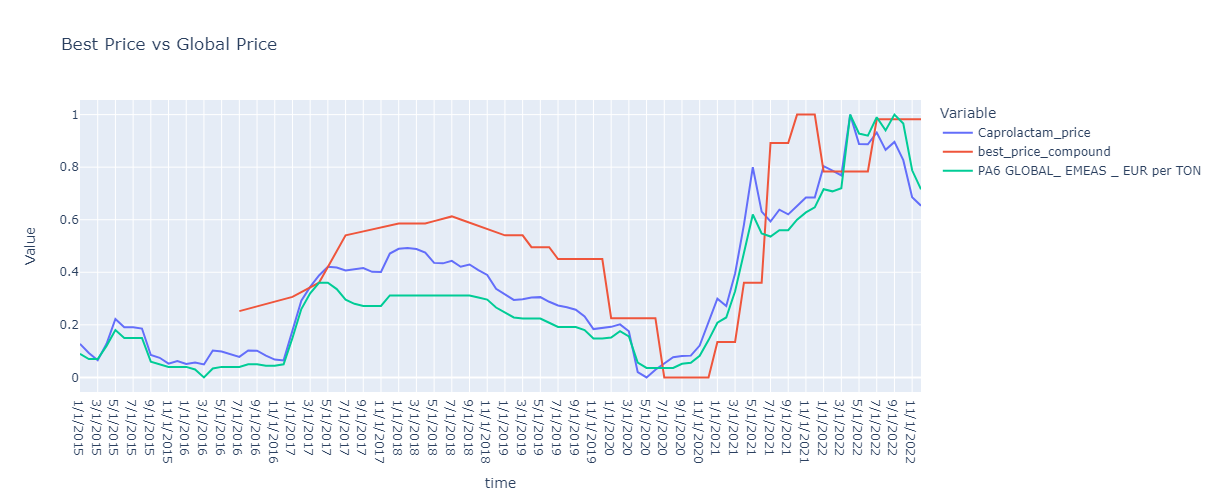

In [128]:
subcols = rest
df_selected = df_normalized.loc[:, ['Caprolactam_price', 'best_price_compound', 'PA6 GLOBAL_ EMEAS _ EUR per TON']]
df_melted = df_selected.reset_index().melt(id_vars=df_selected.index.name, var_name='Variable', value_name='Value')
fig = px.line(df_melted, x=df_selected.index.name, y='Value', color='Variable', title='Best Price vs Global Price')
fig.update_layout(width=1300, height=500)
fig.show()

**First of all, Caprolactam and PA6 are extremely correlated. And secondly, there seems to be a lead-lag relationship between Caprolactam and the best price compound. Let us shift forward Caprolactam by 1 to three months and look at the correlation with the best price.**

In [158]:
for i in range(1, 4):
    print(i)

1
2
3


In [154]:
for i in range(1, 4):
    data[f'Caprolactam_price_shifted_{i}'] = data['Caprolactam_price'].shift(i)

In [155]:
initial_correlation = data['best_price_compound'].corr(data['Caprolactam_price'])
correlation_shift_1 = data['best_price_compound'].corr(data['Caprolactam_price'].shift(1))
correlation_shift_2 = data['best_price_compound'].corr(data['Caprolactam_price'].shift(2))
correlation_shift_3 = data['best_price_compound'].corr(data['Caprolactam_price'].shift(3))

(initial_correlation, correlation_shift_1, correlation_shift_2, correlation_shift_3)

(0.8240709169364435,
 0.8628916304723824,
 0.9099160433552692,
 0.9340219382310487)

**The correlation for shift 3 is the highest, which can also be observed visually!!**

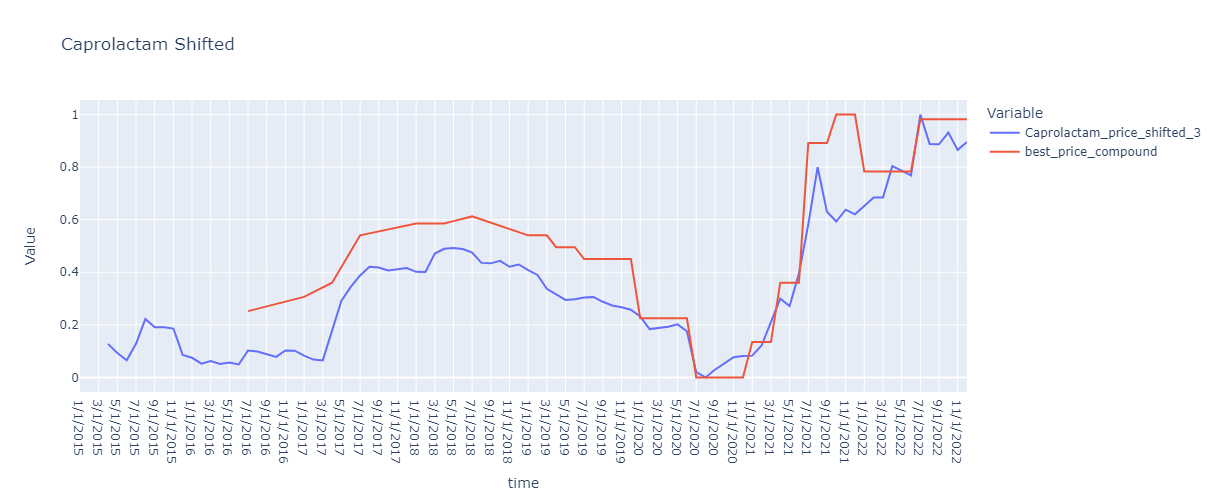

In [160]:
scaler = MinMaxScaler()
df_normalized = pd.DataFrame(scaler.fit_transform(data), index=data.index, columns=data.columns)
df_selected = df_normalized.loc[:, ['Caprolactam_price_shifted_3', 'best_price_compound']]
df_melted = df_selected.reset_index().melt(id_vars=df_selected.index.name, var_name='Variable', value_name='Value')
fig = px.line(df_melted, x=df_selected.index.name, y='Value', color='Variable', title='Caprolactam Shifted')
fig.update_layout(width=1300, height=500)
fig.show()

# Feature Engineering

In [122]:
data = pd.read_csv("data/PA6_cleaned_dataset.csv", index_col='time')
data = data.drop(data.columns[0], axis = 1)

In [123]:
dl = pl.from_pandas(data)

In [21]:
dl.drop(['CRUDE_PETRO', 'CRUDE_BRENT', 'CRUDE_DUBAI', 'NGAS_US', 'NGAS_EUR', 'NGAS_JP', 'Cyclohexane_price', 'Electricty_Price_France', 'Electricty_Price_Italy', 'Electricty_Price_Poland', 'Electricty_Price_Netherlands'])

NameError: name 'dl' is not defined